# Preprocess Video Frames Script

This script performs the following steps:
  1. Iterates over each .avi file in the input directory.
  2. Loads the video frames (extracting one frame per second).
  3. Crops each frame to the region of interest and applies CLAHE enhancement.
  4. Saves the processed frames to an output directory (organized by video filename).

Requirements:
  - OpenCV
  - os
  - numpy
  - Python 3.x

### Import

In [2]:
import os
import cv2
import numpy as np

### Define input and output paths

In [174]:
video_path = 'C:/Users/linus/NematodeAI/0_Data/Videos/2025.03.21_gemischte Stadien aus Fermenterlauf D31220_Tag 8/C0105.MP4'   # Replace with your video p
output_dir =  'C:/Users/linus/NematodeAI/0_Data/Frames'  # Output directory for processed frames
FRAMES = 4  # Number of frames to extract per second

### Helper Functions

In [175]:
def preprocess_frame(frame, clahe):
    """
    Convert the frame to grayscale, apply CLAHE, and convert back to 3-channel.
    """
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    enhanced_frame = clahe.apply(gray_frame)
    return cv2.cvtColor(enhanced_frame, cv2.COLOR_GRAY2BGR)

def load_video_frames(video_path):
    """
    Load video frames into a list of numpy arrays.
    Extracts one frame per second.
    """

    if not os.path.exists(video_path):
        print(f"Error: File does not exist at {video_path}")
    
    cap = cv2.VideoCapture(str(video_path))
        # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return []
                               
    frame_interval = 1             # One frame per second
    frame_count = 0
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

def watershed (img):
    """""
    Apply watershed algorithm to an image.
    """""
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=10)
    return sure_bg

def houghCircle (img, param1, param2, minRadius, maxRadius):
    """"
    Apply Hough Circle Transform to an image. Returns array of circles detected [centerx, centery, radius].
    """""
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=30,param2=10,minRadius=900,maxRadius=1030)
    return circles

def crop_image(img, x, y, r, tolerance):
    """
    Crop the image to the specified region of interest.
    Ensures the crop region does not exceed image boundaries.
    """
    r = r + tolerance
    x_start = max(0, x - r)
    x_end = min(img.shape[1], x + r)
    y_start = max(0, y - r)
    y_end = min(img.shape[0], y + r)
    cropImage = img[y_start:y_end, x_start:x_end]
    return cropImage

def mask_image(img, r):
    """
    Apply mask to an image according to the circle detected.
    Ensures the mask region does not exceed image boundaries.
    """
    mask = np.zeros_like(img)
    center_x = min(max(r, mask.shape[1] // 2), mask.shape[1] - r)
    center_y = min(max(r, mask.shape[0] // 2), mask.shape[0] - r)
    cv2.circle(mask, (center_x, center_y), r, (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def clahe(img):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.
    """
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    img = clahe.apply(img)
    return img

def transform_frames_to_grayscale(frames):
    """
    Transform an array of frames to single-channel grayscale images with uint8 data type.

    Args:
        frames (list of numpy.ndarray): List of frames (images) to be transformed.

    Returns:
        list of numpy.ndarray: List of transformed grayscale frames.
    """
    transformed_frames = []
    for idx, frame in enumerate(frames):
        # Check if the frame is valid
        if frame is None:
            print(f"Warning: Frame {idx} is None and will be skipped.")
            continue

        # Convert to grayscale if the frame has 3 channels (e.g., BGR)
        if len(frame.shape) == 3:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray_frame = frame  # Assume it's already grayscale

        # Ensure the frame is of type uint8
        if gray_frame.dtype != np.uint8:
            gray_frame = cv2.normalize(gray_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Append the transformed frame to the list
        transformed_frames.append(gray_frame)

    return transformed_frames

def crop_video(video_path, h, w, x, y, r): 
    
    output_size = (h, w)  # Desired output size (height, width)

    cap = cv2.VideoCapture(video_path)

    # Read first frame and detect circle
    ret, frame = cap.read()
    if not ret:
        return

    os.makedirs(output_dir, exist_ok=True)

    # Set output path
    output_path = os.path.join(output_dir, os.path.basename(video_path).replace('.MP4', '_cropped.mp4'))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, output_size)

    # Process frames
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cropped_img = crop_image(frame, x, y, r, 10)
        masked_image = mask_image(cropped_img, r)
        resized_image = cv2.resize(masked_image, output_size)
        out.write(resized_image)
        frame_count += 1
        if frame_count % 100 == 0:
            print(f"Processed {frame_count} frames")

    print(f"Finished processing {frame_count} frames")
    print(f"Saved video to: {output_path}")
    cap.release()
    out.release()

### Visualize Data

Processing video: C:/Users/linus/NematodeAI/0_Data/Videos/2025.03.21_gemischte Stadien aus Fermenterlauf D31220_Tag 8/C0105.MP4


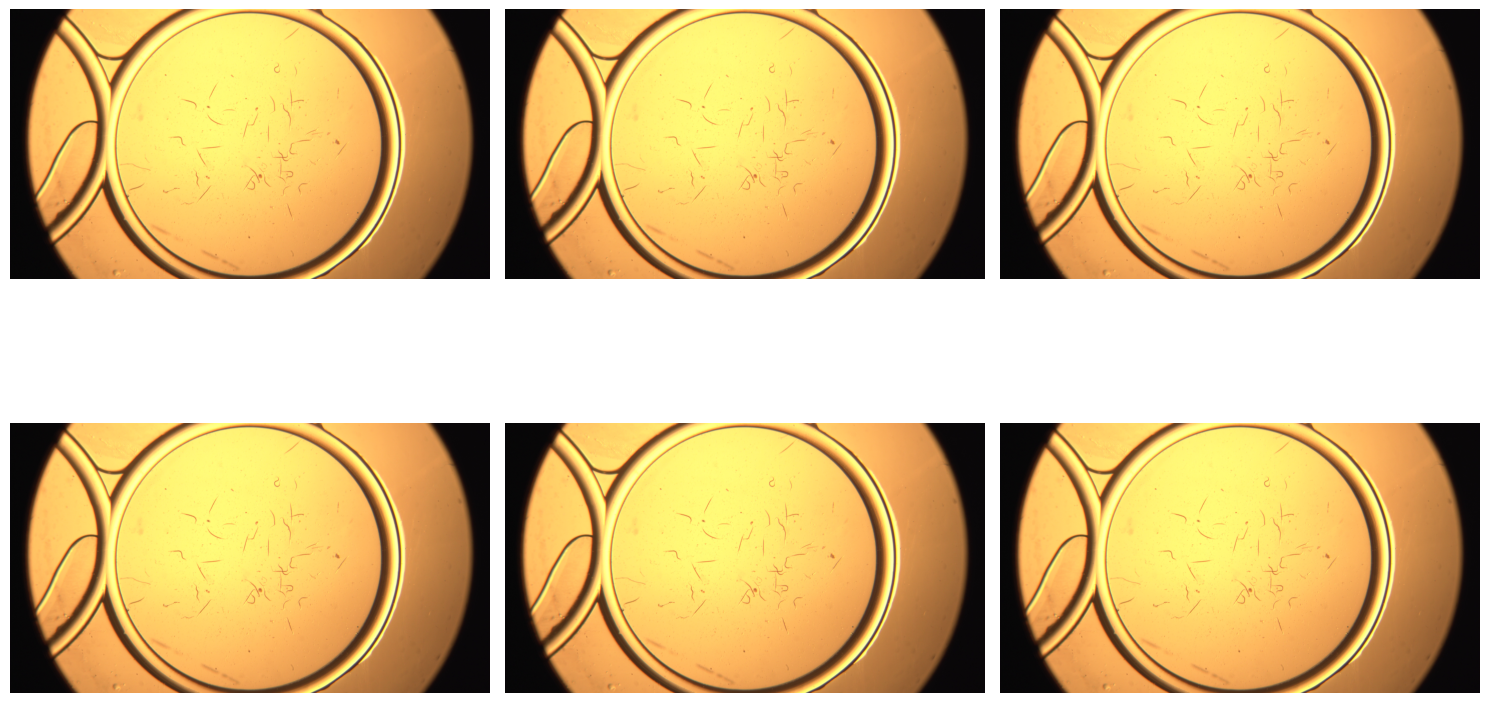

In [176]:
os.makedirs(output_dir, exist_ok=True)
        
print(f"Processing video: {video_path}")

# Load frames (FRAMES per second)
frames = load_video_frames(video_path)
if not frames:
    print(f"WARNING: No frames extracted from video.")
    exit(1)

# Display the extracted frames side by side
import matplotlib.pyplot as plt

# Display 6 extracted frames in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axes.flat):
    if idx < len(frames):
        ax.imshow(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplots
plt.tight_layout()
plt.show()

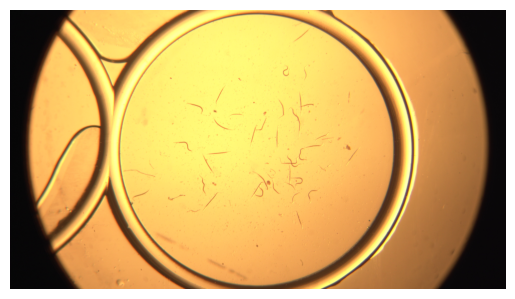

Image shape: (2160, 3840, 3), dtype: uint8


In [177]:
plt.imshow(cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better visualization
plt.show()
print(f"Image shape: {frames[5].shape}, dtype: {frames[5].dtype}")

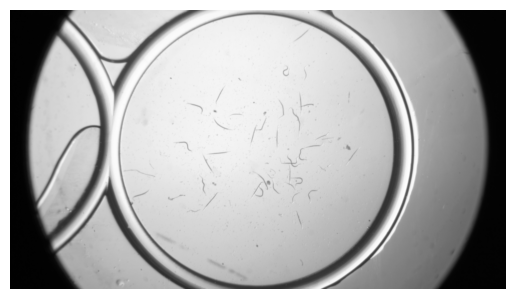

In [178]:
frames = transform_frames_to_grayscale(frames)
gray_blurred = cv2.GaussianBlur(frames[5], (11, 11), 0)
plt.imshow(gray_blurred, cmap='gray')
# plt.imshow(clahe_img, cmap='gray')
plt.axis('off')  # Hide axes for better visualization
plt.show()


Circle detected in image
Circle center: (1892, 1102), radius: 1029


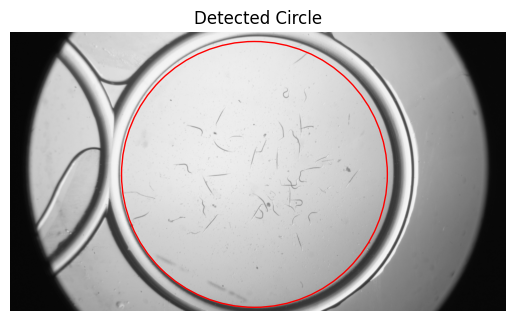

In [179]:
circles = houghCircle(gray_blurred, 40, 20, 990, 1030)
if circles is not None:
    print(f"Circle detected in image")
    circles = np.uint16(np.around(circles))
    max_circle = max(circles[0, :], key=lambda x: x[2])
    x, y, r = max_circle

print(f"Circle center: ({x}, {y}), radius: {r}")

# Display the frame with the circle
plt.imshow(cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Circle((x, y), r, color='r', fill=False))
plt.title("Detected Circle")
plt.axis('off')  # Hide axes for better visualization
plt.show()

(np.float64(-0.5), np.float64(2077.5), np.float64(2077.5), np.float64(-0.5))

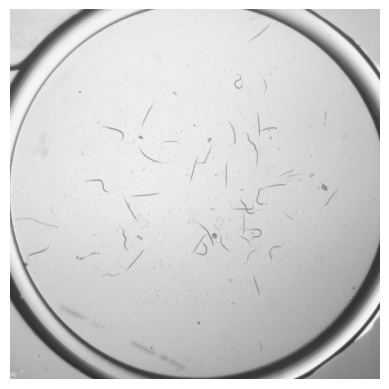

In [180]:
cropped_img = crop_image(frames[5], x, y, r, 10)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.axis('off') 

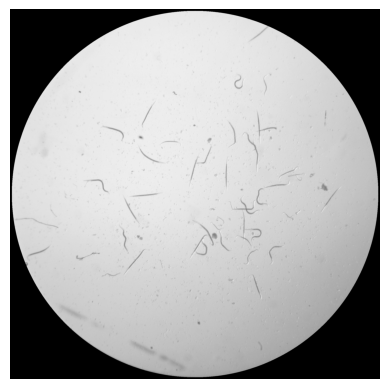

In [181]:
masked_image = mask_image(cropped_img, r)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better visualization
plt.show()

## Execute Preprocessing if results are sufficient

In [182]:
# Create output directory using video filename
base_name = os.path.splitext(os.path.basename(video_path))[0]
video_output_dir = os.path.join(output_dir, base_name)
os.makedirs(video_output_dir, exist_ok=True)

# Save each processed frame as an image file
gray_blurred = cv2.GaussianBlur(frames[5], (11, 11), 0)

# Apply Hough Circle Transform
circles = houghCircle(gray_blurred, 40, 20, 990, 1030)

if circles is not None:
    print(f"Circle detected in image")
    circles = np.uint16(np.around(circles))
    max_circle = max(circles[0, :], key=lambda x: x[2])
    x, y, r = max_circle

if circles is not None:
    for idx, frame in enumerate(frames):
        output_filename = f"{base_name}_frame_{idx}.jpg"
        output_path = os.path.join(video_output_dir, output_filename)
        print(f"Processing frame {idx + 1}/{len(frames)}: {output_filename}")
        cropped_img = crop_image(frame, x, y, r, 10)
        masked_image = mask_image(cropped_img, r)
        
        # Save the processed image
        cv2.imwrite(output_path, masked_image)
        print(f"Saved preprocessed frame: {output_path}")
else:
    print("No circles detected. Skipping frame processing.")

w, h = masked_image.shape[:2]
crop_video(video_path, h, w, x, y, r)
        

Circle detected in image
Processing frame 1/252: C0105_frame_0.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_0.jpg
Processing frame 2/252: C0105_frame_1.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_1.jpg
Processing frame 3/252: C0105_frame_2.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_2.jpg
Processing frame 4/252: C0105_frame_3.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_3.jpg
Processing frame 5/252: C0105_frame_4.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_4.jpg
Processing frame 6/252: C0105_frame_5.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_5.jpg
Processing frame 7/252: C0105_frame_6.jpg
Saved preprocessed frame: C:/Users/linus/NematodeAI/0_Data/Frames\C0105\C0105_frame_6.jpg
Processing frame 8/252: C0105_frame_7.jpg
Saved pre